In [0]:
import logging
from nltk import word_tokenize
import pandas as pd
import numpy as np
import gc
import os
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
#from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from torch import optim
import torchtext
import random

In [16]:
import os
os.environ['CUDA_VISBLE_DEVICES'] = '0'
use_cude = True

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla K80'

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare data


In [18]:
data = pd.read_csv("/content/drive/My Drive/nlp-data/train_dataset4.csv", header=None)
headers = ['rank', 'word', 'part_of_speech', 'frequency', 'dispersion', 'dictionary_def', 'word_embed', 'dic_embed' ]
data.columns = headers
data = data.drop(0)

word_list = data['word'].values.tolist()
word_list = [string.replace(u'\xa0\xa0\xa0', u'') for string in word_list]
word_em = data['word_embed'].values.tolist()
dic_em = data['dic_embed'].values.tolist()
print(word_list[0])

the


now convert embedding dataframe from a list of strings to a list of np.array.

In [20]:
def convert_to_array(aa):
  
  aa = aa.split()
  
  if aa[0] == '[[':
  
    #print(len(aa))
    aa[-1] = aa[-1].replace(u']]', u'') 
    aa = aa[1:]
    aa= [float(i) for i in aa]
    aa = np.asarray(aa)
    
  else:
    aa[0] = aa[0].replace(u'[[', u'')
    aa[-1] = aa[-1].replace(u']]', u'') 
    aa= [float(i) for i in aa]
    aa = np.asarray(aa)
    
  return aa

word_embed = []
dic_embed = []
for i in word_em:
  b = convert_to_array(i)
  word_embed.append(b)
  
for j in dic_em:
  c = convert_to_array(j)
  dic_embed.append(c)

print(len(word_embed[1]))
print(len(dic_embed[0]))

768
768


In [0]:
# def normalize(v):
#     norm = np.linalg.norm(v)
#     if norm == 0: 
#        return v
#     return v / norm

# word_embed = [normalize(i) for i in word_embed]
# dic_embed = [normalize(i) for i in dic_embed]
# print(len(word_embed))

# Load data in NN

load data. \\
through torchtext.data.Field define the datatype that are latter to be converted to tensors. \\
target_em =  dictionary embedding \\
scr_em = word_embedding \\
now both text and target are non-sequential data whose embeddings are to be acquired through building vocab

In [22]:
text = torchtext.data.Field(sequential=False, batch_first=True, lower=True)
target = torchtext.data.Field(sequential=False, batch_first=True, lower=True, is_target=True)

train = torchtext.data.TabularDataset(path="/content/drive/My Drive/nlp-data/train_dataset5.csv", format='csv',
                                      fields={'word': ('text', text),
                                              'def_word': ('target',target)})

print(train[1].target)

   be


In [23]:
source_matrix = np.asarray(word_embed)
source_matrix = torch.tensor(source_matrix.reshape(5000, 768))
target_matrix = np.asarray(dic_embed)
target_matrix = torch.tensor(target_matrix.reshape(5000, 768))


text.build_vocab(train)
text.vocab.vectors = source_matrix
print(text.vocab.vectors.shape)

target.build_vocab(train)
target.vocab.vectors = target_matrix


torch.Size([5000, 768])


split train and validation sets

In [0]:

random.seed(2018)
train, val = train.split(split_ratio=0.9, random_state=random.getstate())

# Model

defining model

In [0]:
class FNN(nn.Module):
    def __init__(self, weight, hidden_dim=768, dropout=0.1):
      
        super(FNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(p=dropout)
        self.embedding = nn.Embedding.from_pretrained(weight)
        
        #activation function
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
        self.tanh = nn.Tanh()
        #hidden layers
        self.linear1 = nn.Linear(768, 12)
        self.linear2 = nn.Linear(12, 768)
        #self.linear3 = nn.Linear(768, 768)
    
    def forward(self, x):
        x = torch.transpose(x, dim0=1, dim1=0)
        #print('size x:', x.size())
        
        embeds = self.embedding(x).to(dtype=torch.float32)

        #layer 1
        a = self.linear1(embeds)
        b = self.tanh(self.dropout(a))
        c = self.linear2(b)

        # #layer 2
        # c = self.elu(b)
        # d = self.linear2(self.dropout(c))

        # #layer 3
        # e = self.elu(d)
        # f = self.linear3(self.dropout(e))

        return c


# trainer

In [0]:
train_loss = []
validation_loss = []

def training(epoch, model, target_weight, eval_every, loss_func, optimizer, train_iter, val_iter, early_stop=1, warmup_epoch=2):
    
    step = 0
    max_loss = 1e5
    no_improve_epoch = 0
    no_improve_in_previous_epoch = False
    train_record = []
    val_record = []
    losses = []
      
    
    for e in range(epoch):
        if e >= warmup_epoch:
            if no_improve_in_previous_epoch:
                no_improve_epoch += 1
                if no_improve_epoch >= early_stop:
                    break
            else:
                no_improve_epoch = 0
            no_improve_in_previous_epoch = True
        
        train_iter.init_epoch()
        for train_batch in iter(train_iter):
          
            step += 1
            model.train()

            
            x = train_batch.text.cuda()
            y = train_batch.target.cuda()
            
            model.zero_grad()
            #print(x)
            pred = model.forward(x.unsqueeze(-1)).view(-1)
            
            embedding = nn.Embedding.from_pretrained(target_weight).cuda()
            embedding = embedding.to(dtype=torch.float32)
            y = embedding(y.unsqueeze(0)).view(-1)

            loss = loss_function(pred, y)
            losses.append(loss.cpu().data.numpy())
            train_record.append(loss.cpu().data.numpy())
            loss.backward()
            optimizer.step()
            if step % eval_every == 0:
                model.eval()
                model.zero_grad()
                val_loss = []
                for val_batch in iter(val_iter):
                    val_x = val_batch.text.cuda()
                    val_y = val_batch.target.cuda()
                    val_pred = model.forward(val_x.unsqueeze(-1)).view(-1)

                    val_y = embedding(val_y.unsqueeze(0)).view(-1)
                    
                    val_loss.append(loss_function(val_pred, val_y).cpu().data.numpy())
                val_record.append({'step': step, 'loss': np.mean(val_loss)})
                print('epcoh {:02} - step {:06} - train_loss {:.4f} - val_loss {:.4f} '.format(
                            e, step, np.mean(losses), val_record[-1]['loss']))
                train_loss.append(np.mean(losses))
                validation_loss.append(val_record[-1]['loss'])
                if e >= warmup_epoch:
                    if val_record[-1]['loss'] <= max_loss:
                        save(m=model, info={'step': step, 'epoch': e, 'train_loss': np.mean(losses),
                                            'val_loss': val_record[-1]['loss']})
                        max_loss = val_record[-1]['loss']
                        no_improve_in_previous_epoch = False
    

def save(m, info):
    torch.save(info, 'best_model.info')
    torch.save(m, 'best_model.m')
    
def load():
    m = torch.load('best_model.m')
    info = torch.load('best_model.info')
    return m, info

define the training model 

In [27]:

print('1')
batch_size = 10
train_iter = torchtext.data.Iterator(dataset=train,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               sort=False)
val_iter = torchtext.data.Iterator(dataset=val,
                                             batch_size=batch_size,
                                             train=False,
                                             sort=False)
print('2')
model = FNN(text.vocab.vectors, hidden_dim=768, dropout=0.2).cuda()
print('3')
loss_function = torch.nn.MSELoss()
print('4')
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                    lr=1e-3)#, weight_decay=1e-3)

1
2
3
4


now train...

# Train

In [28]:
training(model=model, target_weight= target.vocab.vectors, epoch=50, eval_every=500,
         loss_func=loss_function, optimizer=optimizer, train_iter=train_iter,
        val_iter=val_iter, warmup_epoch=3, early_stop=2)

epcoh 01 - step 000500 - train_loss 0.2760 - val_loss 0.2693 
epcoh 02 - step 001000 - train_loss 0.2737 - val_loss 0.2683 
epcoh 03 - step 001500 - train_loss 0.2727 - val_loss 0.2676 


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epcoh 04 - step 002000 - train_loss 0.2720 - val_loss 0.2669 
epcoh 05 - step 002500 - train_loss 0.2714 - val_loss 0.2661 
epcoh 06 - step 003000 - train_loss 0.2709 - val_loss 0.2654 
epcoh 07 - step 003500 - train_loss 0.2704 - val_loss 0.2647 
epcoh 08 - step 004000 - train_loss 0.2700 - val_loss 0.2640 
epcoh 09 - step 004500 - train_loss 0.2696 - val_loss 0.2633 
epcoh 11 - step 005000 - train_loss 0.2692 - val_loss 0.2627 
epcoh 12 - step 005500 - train_loss 0.2688 - val_loss 0.2620 
epcoh 13 - step 006000 - train_loss 0.2684 - val_loss 0.2613 
epcoh 14 - step 006500 - train_loss 0.2680 - val_loss 0.2607 
epcoh 15 - step 007000 - train_loss 0.2676 - val_loss 0.2600 
epcoh 16 - step 007500 - train_loss 0.2673 - val_loss 0.2593 
epcoh 17 - step 008000 - train_loss 0.2669 - val_loss 0.2587 
epcoh 18 - step 008500 - train_loss 0.2665 - val_loss 0.2580 
epcoh 19 - step 009000 - train_loss 0.2662 - val_loss 0.2574 
epcoh 21 - step 009500 - train_loss 0.2658 - val_loss 0.2567 
epcoh 22

save state_dic()

In [0]:
model, m_info = load()
m_info

torch.save(model.state_dict(), "/content/drive/My Drive/nlp-data/fnn_reversed.pt")

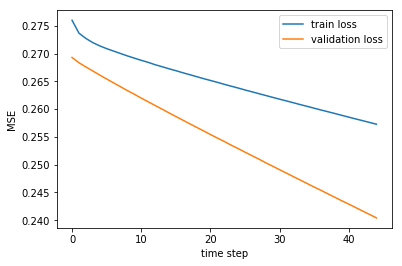

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss)), train_loss, label = 'train loss')
plt.plot(range(len(train_loss)), validation_loss, label = 'validation loss')
plt.legend()
plt.ylabel('MSE')

plt.xlabel('time step')
plt.savefig("/content/drive/My Drive/train.png", dpi=500)

In [0]:
data = pd.read_csv(r"/content/drive/My Drive/nlp-data/eval/cat_all.csv", header = None)

word_em = data[2][1:].values.tolist()
def_em = data[3][1:].values.tolist()
words = data[0][1:].values.tolist()
word2 = data[1][1:].values.tolist()


word_embed = []
def_embed = []

def convert_to_array(aa):
  
  aa = aa.split()
  
  if aa[0] == '[[':
  
    #print(len(aa))
    aa[-1] = aa[-1].replace(u']]', u'') 
    aa = aa[1:]
    aa= [float(i) for i in aa]
    aa = np.asarray(aa)
    
  else:
    aa[0] = aa[0].replace(u'[[', u'')
    aa[-1] = aa[-1].replace(u']]', u'') 
    aa= [float(i) for i in aa]
    aa = np.asarray(aa)
    
  return aa

for i in word_em:
  b = convert_to_array(i)
  word_embed.append(b)

for i in def_em:
  b = convert_to_array(i)
  def_embed.append(b)

# word_embed = [normalize(i) for i in word_embed]
# def_embed = [normalize(f) for f in def_embed]
embed_tt = word_embed+def_embed
word_tt = words+word2


In [0]:
x_matrix = np.asarray(word_embed)
x_matrix = torch.tensor(x_matrix.reshape(len(word_embed), 768))
zero_pad = torch.zeros(5000-len(x_matrix), 768)
x_matrix = torch.tensor(np.vstack((x_matrix, zero_pad)))

In [0]:
model_1 = FNN(x_matrix, hidden_dim=768, dropout=0.2).cuda()
model_1.load_state_dict(torch.load('/content/drive/My Drive/nlp-data/fnn_reversed.pt')) #/content/drive/My Drive/nlp-data/bi-lstem1_reversed.pt， /content/drive/My Drive/nlp-data/bi-lstem1.pt
model_1.eval()

new_embed2=[]
for i in range(len(x_matrix)):
  x = torch.tensor([int(i)]).cuda()
  pred_x = model_1.forward(x.unsqueeze(-1)).view(-1)
  pred_x = torch.Tensor.cpu(pred_x).detach().numpy()
  new_embed2.append(pred_x)


In [0]:

embed_tt = def_embed+new_embed2[:7]
word_tt = word2 +['cat_t', 'tiger_t', 'lion_t', 'lynx_t', 'caracal_t', 'cougar_t', 'ocelot_t']

In [35]:
len(embed_tt)

14

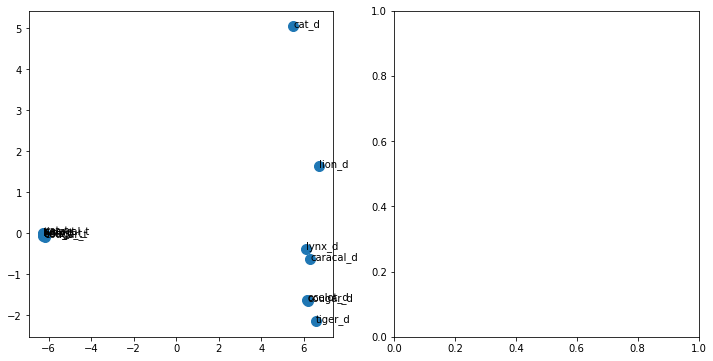

In [36]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

my_embed=embed_tt
X = [x.reshape(-1,) for x in my_embed]
tsne_model = PCA(n_components=2)
X_embedded = tsne_model.fit_transform(X)

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_embedded[:,0], X_embedded[:,1], s=100)
zoom = [(x,tx) for x,tx in zip(X_embedded, word_tt) ]
for i, txt in zoom:
     ax[0].annotate(txt, (i[0], i[1]))

# prepare embedding for downstream task

In [37]:
df1 = pd.read_csv("/content/drive/My Drive/nlp-data/def_embed_150k.csv", header=None)
df2 = pd.read_csv("/content/drive/My Drive/nlp-data/150_syn_dic_embed.csv", header=None)
df3 = pd.read_csv("/content/drive/My Drive/nlp-data/150_syns.csv", header=None)
df4 = pd.read_csv("/content/drive/My Drive/nlp-data/eval/150_bert_embed.csv", header=None)
df5 = pd.read_csv("/content/drive/My Drive/nlp-data/eval/2415_bert_syns_embed.csv", header=None)

index = np.arange(150)
num_syn = df3[3][1:].values.tolist()
num_syn = [int(i) for i in num_syn]
print(num_syn)

d = {}
for i in np.arange(150):
  d[str(i)] = num_syn[i]
print(d)

word_em = df1[1][1:].values.tolist() #dic
syn_em = df2[1][1:].values.tolist() 
bert_em = df4[1][1:].values.tolist() #bert
bert_syn_em = df5[1][1:].values.tolist()

[4, 23, 25, 41, 81, 40, 27, 30, 30, 10, 20, 17, 16, 12, 8, 14, 111, 5, 25, 20, 19, 29, 11, 25, 3, 23, 17, 8, 28, 24, 32, 17, 2, 16, 10, 7, 20, 10, 15, 1, 16, 4, 11, 17, 11, 7, 86, 29, 12, 16, 26, 10, 3, 6, 9, 7, 6, 10, 11, 13, 6, 4, 4, 15, 28, 6, 14, 9, 5, 2, 10, 7, 42, 2, 11, 7, 3, 14, 32, 22, 27, 5, 6, 32, 22, 4, 9, 24, 21, 12, 16, 5, 7, 11, 3, 7, 15, 30, 14, 8, 3, 7, 9, 5, 19, 14, 21, 2, 28, 9, 48, 10, 8, 33, 14, 13, 23, 21, 7, 35, 4, 19, 6, 16, 6, 8, 9, 10, 7, 27, 20, 63, 13, 20, 19, 6, 14, 1, 5, 13, 1, 8, 10, 13, 12, 31, 5, 2, 6, 5]
{'0': 4, '1': 23, '2': 25, '3': 41, '4': 81, '5': 40, '6': 27, '7': 30, '8': 30, '9': 10, '10': 20, '11': 17, '12': 16, '13': 12, '14': 8, '15': 14, '16': 111, '17': 5, '18': 25, '19': 20, '20': 19, '21': 29, '22': 11, '23': 25, '24': 3, '25': 23, '26': 17, '27': 8, '28': 28, '29': 24, '30': 32, '31': 17, '32': 2, '33': 16, '34': 10, '35': 7, '36': 20, '37': 10, '38': 15, '39': 1, '40': 16, '41': 4, '42': 11, '43': 17, '44': 11, '45': 7, '46': 86, '47'

In [38]:
def convert_to_array(aa):
  
  aa = aa.split()
  
  if aa[0] == '[[':
  
    #print(len(aa))
    aa[-1] = aa[-1].replace(u']]', u'') 
    aa = aa[1:]
    aa= [float(i) for i in aa]
    aa = np.asarray(aa)
    
  else:
    aa[0] = aa[0].replace(u'[[', u'')
    aa[-1] = aa[-1].replace(u']]', u'') 
    aa= [float(i) for i in aa]
    aa = np.asarray(aa)
    
  return aa

word_embed = []
syn_embed = []
bert_syn_embed = []
bert_embed = []

for i in word_em:
  b = convert_to_array(i)
  word_embed.append(b)
  
for j in syn_em:
  c = convert_to_array(j)
  syn_embed.append(c)
  
for j in bert_em:
  c = convert_to_array(j)
  bert_embed.append(c)
  
for j in bert_syn_em:
  c = convert_to_array(j)
  bert_syn_embed.append(c)
  

print(len(bert_syn_embed))

2415


In [0]:
x_matrix = np.asarray(word_embed) #dic
x_matrix = torch.tensor(x_matrix.reshape(150, 768)) #dic
syn_matrix = np.asarray(syn_embed) #dic
syn_matrix = torch.tensor(syn_matrix.reshape(2415, 768)) #dic

b_matrix = np.asarray(bert_embed) #bert
b_matrix = torch.tensor(b_matrix.reshape(150, 768))
b_syn_matrix = np.asarray(bert_syn_embed)
b_syn_matrix = torch.tensor(b_syn_matrix.reshape(2415, 768))

In [0]:
#dff = pd.read_csv('/content/drive/My Drive/nlp-data/berkeley/dic_vec.txt', header=None)
f=open('/content/drive/My Drive/nlp-data/bert.vec.txt',"r")
lines=f.readlines()
result=[]
for x in lines:
    result.append(x)
f.close()

In [0]:
word_list = []
em_list = []
for i in range(len(result)):

  w = result[i].split()
  word_list.append(w[0])
  vec = w[1:]
  em = []
  for j in vec:
    em.append(float(j))
  em_list.append(em)

In [0]:

x_matrix = np.asarray(em_list[:5000])
x_matrix = torch.tensor(x_matrix.reshape(5000, 768))
x2_matrix = np.asarray(em_list[5000:10000])
x2_matrix = torch.tensor(x2_matrix.reshape(5000, 768))
x3_matrix = np.asarray(em_list[10000:])
x3_matrix = torch.tensor(x3_matrix.reshape(len(em_list[10000:]), 768))

In [43]:
zero_pad = torch.zeros(5000-len(em_list[10000:]), 768)
x3_matrix = torch.tensor(np.vstack((x3_matrix, zero_pad)))

model_1 = FNN(x_matrix, hidden_dim=768, dropout=0.2).cuda()
model_1.load_state_dict(torch.load('/content/drive/My Drive/nlp-data/fnn_reversed.pt'))
model_2 = FNN(x2_matrix, hidden_dim=768,  dropout=0.2).cuda()
model_2.load_state_dict(torch.load('/content/drive/My Drive/nlp-data/fnn_reversed.pt'))
model_3 = FNN(x3_matrix, hidden_dim=768, dropout=0.2).cuda()
model_3.load_state_dict(torch.load('/content/drive/My Drive/nlp-data/fnn_reversed.pt'))
model_1.eval()
model_2.eval()
model_3.eval()

FNN(
  (dropout): Dropout(p=0.2)
  (embedding): Embedding(5000, 768)
  (relu): ReLU()
  (elu): ELU(alpha=1.0)
  (tanh): Tanh()
  (linear1): Linear(in_features=768, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=768, bias=True)
)

In [0]:
l1 = []
l2 = []
l3 = []
for i in range(5000):
  a = torch.tensor([i]).cuda()

  batch_a = model_1.forward(a.unsqueeze(-1)).view(-1)
  batch_b = model_2.forward(a.unsqueeze(-1)).view(-1)
  batch_c = model_3.forward(a.unsqueeze(-1)).view(-1)
  l1.append(torch.Tensor.cpu(batch_a).detach().numpy())
  l2.append(torch.Tensor.cpu(batch_b).detach().numpy())
  l3.append(torch.Tensor.cpu(batch_c).detach().numpy())

list_embed = l1+l2+l3

In [0]:
list_embed = list_embed[:10156]

DAT =  np.column_stack((word_list, list_embed))
    
np.savetxt('/content/drive/My Drive/nlp-data/berkeley/fnn_vec.txt', DAT, delimiter=" ", fmt='%s') 